# Hands-On Series de tiempo
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/armandoordonez/testing/blob/main/Unidad%201%20-%20Time%20Series/estadistica-basica.ipynb)

En este notebook se cubrira un caso muy sencillo pero ilustrativo. El conjunto de datos será el [Shampoo Sales Dataset](https://www.kaggle.com/datasets/redwankarimsony/shampoo-saled-dataset?select=shampoo_sales.csv) disponible de forma libre en Kaggle (click en el enlace). El dataset consiste en el número de ventas de shampoo en el transcurso de un año y par de meses. 

El objetivo principal es observar este dataset desde dos ángulos:

- Sus propiedades estadísticas
- Un ejemplo de inferencia con un modelo lineal

## Carga del dataset

In [1]:
import pkg_resources
import os

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget https://github.com/armandoordonez/testing/raw/main/requirements.txt && pip install -r requirements.txt

In [3]:
!test '{IN_COLAB}' = 'True' && mkdir -p datasets/ && wget https://github.com/armandoordonez/testing/raw/main/datasets/shampoo_sales.csv -O datasets/shampoo_sales.csv

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

warnings.simplefilter(action="ignore", category=FutureWarning)

# Cambiar según la localización del archivo.
if IN_COLAB:
  dataset_path = './datasets/shampoo_sales.csv'
else:
  dataset_path = '../datasets/shampoo_sales.csv'

dataset = pd.read_csv(dataset_path)
dataset.head(15)

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


## Datos estadísticos

Primero, observamos algunos datos estadísticos descriptivos, como la cantidad de datos, media, desvicación estándar, mínimos, máximos y unos cuantos percentiles. Esto nos ayudará a evaluar inicialmente la consistencia de los datos que tenemos a mano, detectar posibles anormalidades, entre otros.

In [2]:
dataset.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


## Visualización

La visualización es muy importante ya que facilita mucho un entendimiento global sobre los datos, detección de posibles anomalías o peculiaridades del dataset que puedan afectar el proceso.

### Histograma
Empezando por el histograma para observar la distribución de los valores que observamos. Esto es importante ya que si por ejemplo la distribución está muy lejos de una forma normal, esto puede afectar el rendimiento de las técnicas que dependen de los estadísticos básicos.

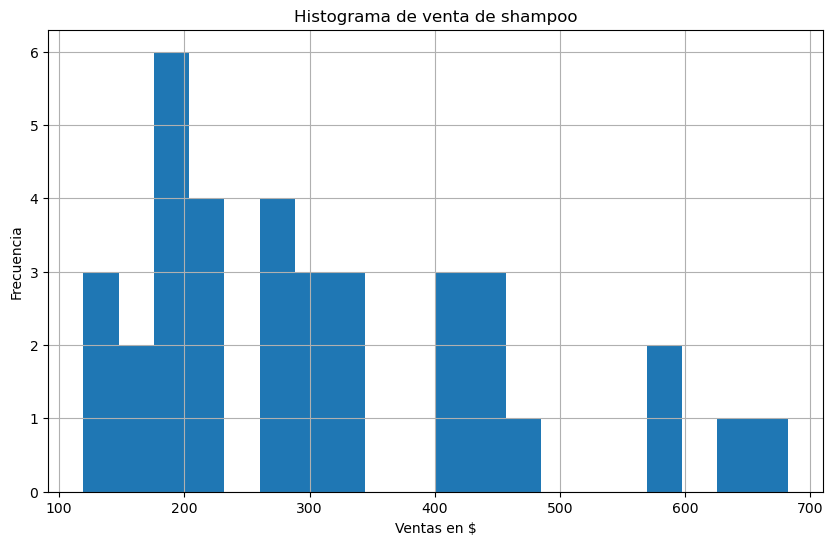

In [3]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Ventas en $")
ax.set_ylabel("Frecuencia")

dataset.hist(figsize=(10, 6), ax=ax, bins=20)

plt.title("Histograma de venta de shampoo")
plt.show()

Aquí por ejemplo, podemos observar nuevamente el histograma pero graficando una estimación de su distribución. Podemos observar que no es precisamente normal, pero puede aún funcionar.

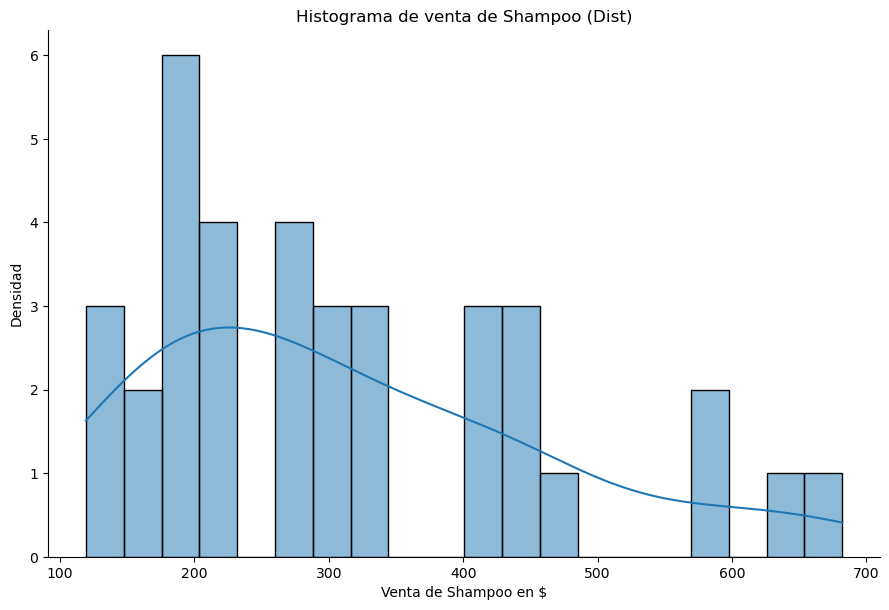

In [4]:
sns.displot(dataset['Sales'], kind='hist', kde=True, bins=20, height=6, aspect=1.5)
plt.title("Histograma de venta de Shampoo (Dist)")
plt.xlabel("Venta de Shampoo en $")
plt.ylabel("Densidad")
plt.show()

### Diagrama de dispersión + Diagrama de línea

En series de tiempo, este es el diagrama más importante ya que es sencillamente la evolución de la variable dependiente en el tiempo, es aquí donde podemos observar los patrones discutidos en las lecturas. Podemos visualmente observar si hay tendencia, ciclos, temporadas o si de plano no estamos observando una serie de tiempo.

No vale la pena continuar si no observamos un patrón claro. Recordemos que NO es una serie de tiempo cuando no se detecta ninguno de los siguientes patrones:
- Tendencia: Que se observe que los datos tienden a ascender o descender de forma regular.
- Temporalidad: Que a intervalos en frecuencias regulares, se observen patrones similares.
- Ciclos: Que se observen alzas o caidas en frecuencias no regulares, pero que se perciba un cambio de patrón entre ellas, los ciclos generalmente son largos.

Cabe aclarar que no siempre tienen que estar las tres características al mismo tiempo, pero si al menos una.

Por ejemplo, en el caso de las ventas de shampoo, en el diagrama abajo se puede observar que, a pesar de haber fluctuación a medida que avanza el tiempo, hay una clara tendencia ascendente. Además de eso, si se observa con atención, hay picos de ventas al rededor del mes de noviembre en los 3 años de los cuales hay datos, lo cual indica temporalidad. Finalmente, no se observa ningún ciclo particular ya que toda la serie obedece el mismo patrón descrito.

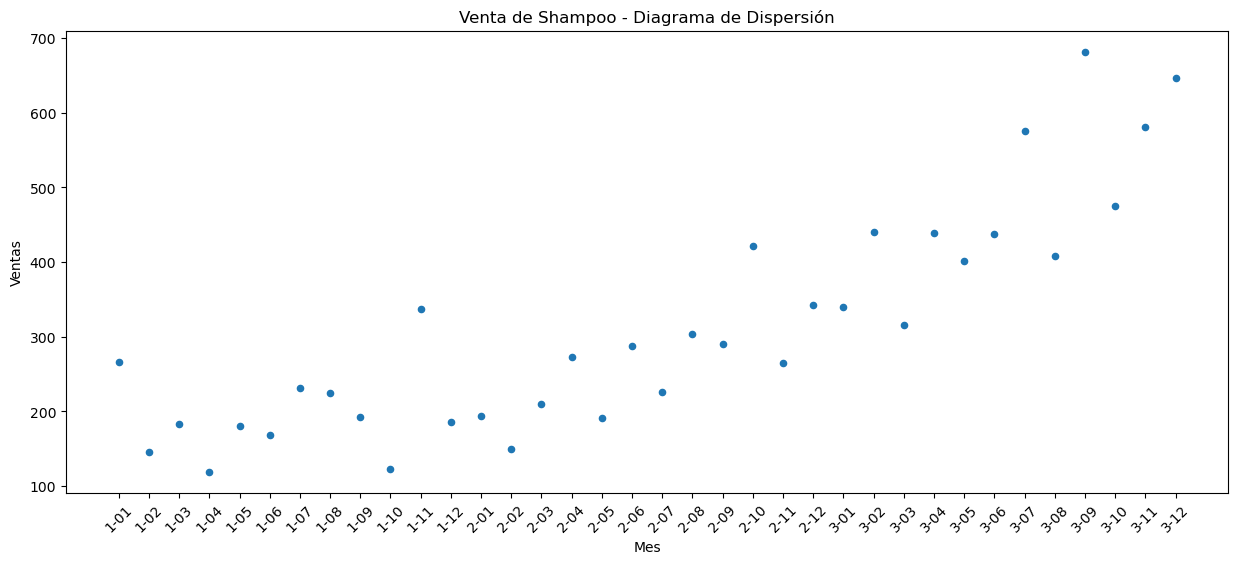

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot.scatter(x='Month', y='Sales', ax=ax)
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.tick_params(axis='x', labelrotation=45)
plt.title("Venta de Shampoo - Diagrama de Dispersión")
plt.show()

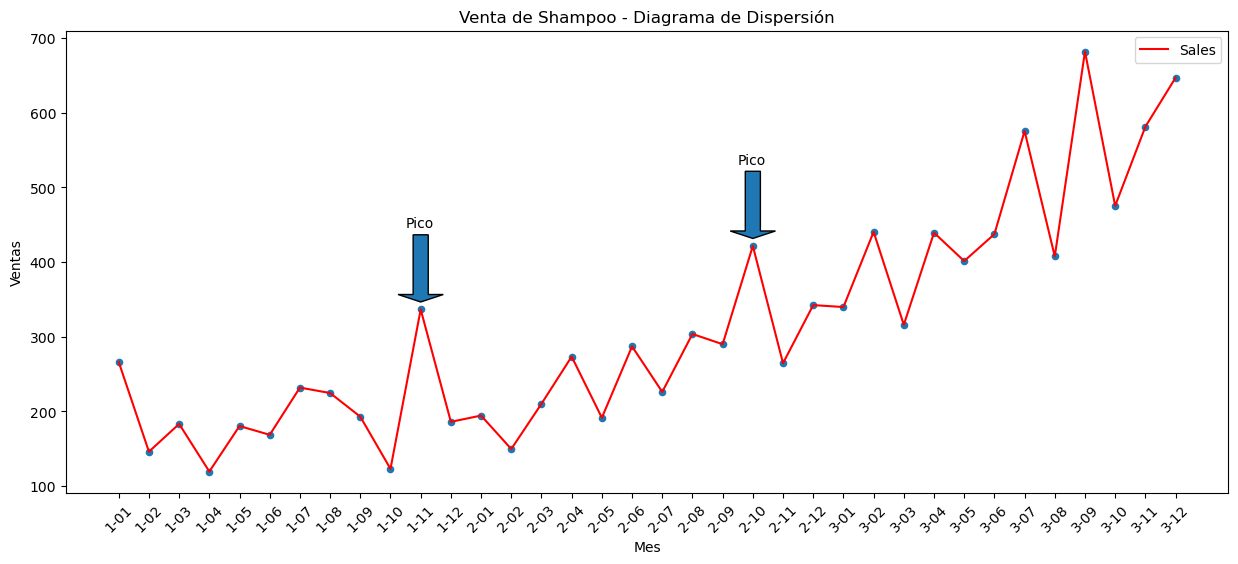

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot.scatter(x='Month', y='Sales', ax=ax)
dataset.plot.line(x='Month', y='Sales', ax=ax, color="red")

ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.tick_params(axis='x', labelrotation=45)

spikes = dataset.iloc[[10, 21]]
for idx in spikes.index:
    sales = spikes['Sales'][idx]
    ax.arrow(idx, sales + 100, 0, -80, width=0.5, head_length=10)
    ax.text(idx - 0.5, sales + 110, "Pico")

plt.title("Venta de Shampoo - Serie de Tiempo")
plt.show()

## Estadística Inferencial

Entrenando un modelo de regresión lineal simple de tipo $f(x) = mx + b$, donde $m$ es la pendiente de la recta y $b$ es su intercepto.

In [6]:
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown as md

# Usamos los indices porque la regresión lineal no funciona con strings
x = dataset.Month.index.to_numpy().reshape(-1, 1)
y = dataset.Sales.to_numpy().reshape(-1, 1)

lr = LinearRegression()

lr.fit(x, y)
pendiente_m = float(lr.coef_[0][0])
intercepto_b = float(lr.intercept_[0])
md(f"Modelo de regresión lineal $f(x) = {pendiente_m:.2f}x + {intercepto_b:.2f}$")

Modelo de regresión lineal $f(x) = 12.08x + 101.22$

### ¿Cómo se ajusta este modelo a los datos?

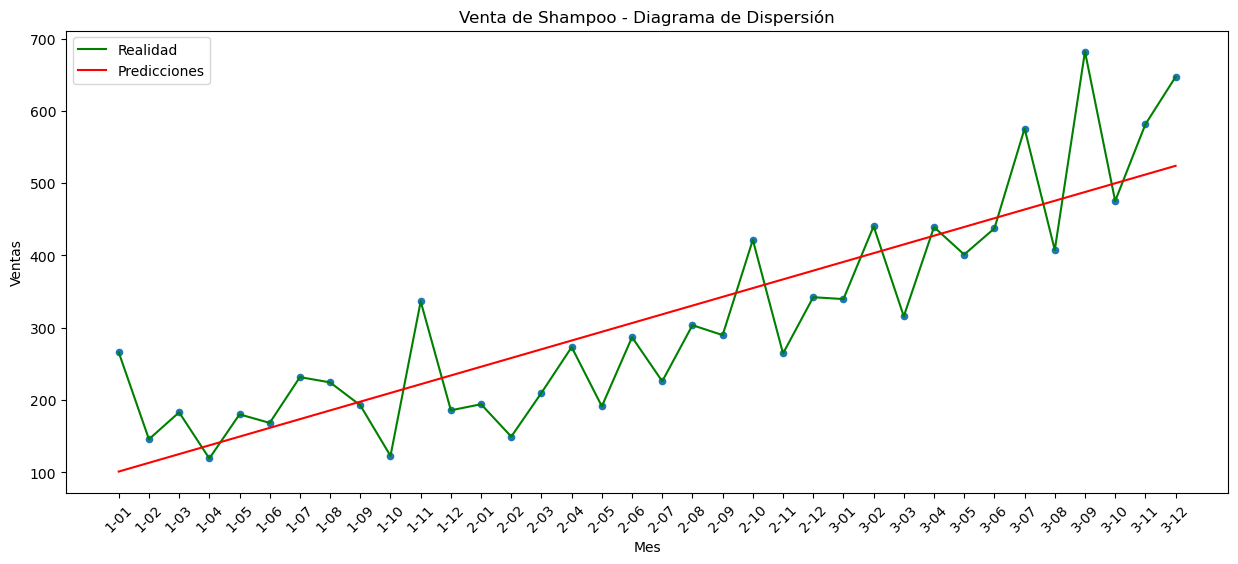

In [7]:
predicciones = lr.predict(x)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot.scatter(x='Month', y='Sales', ax=ax)
dataset.plot.line(x='Month', y='Sales', ax=ax, color="green", label="Realidad")
ax.plot(x, predicciones, color="red", label="Predicciones")
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.legend()
ax.tick_params(axis='x', labelrotation=45)
plt.title("Venta de Shampoo - Modelo lineal")
plt.show()


Muy regular

El modelo de regresión lineal solamente es capaz de capturar la tendencia de los datos, pero es incapaz de hacer buenas predicciones sobre los puntos.

Un modelo de regresión lineal simple solamente tiene dos (o a veces hasta solo uno) parametros, la pendiente y el intercepto, y estos solamente explican el cambio generalizado entre los puntos, no tiene en cuenta que los datos futuros están correlacionados con los anteriores, además, como es de esperarse en una serie de tiempo real, los cambios entre el paso de tiempo no es suave y un modelo simple es sencillamente incapaz de capturar ciclos y patrones temporales, razón por la cual se deben usar modelos más especializados.

#### Nota
Puede que nos encontremos con series de tiempo con patrones muy sencillos, solo con tendencia, sin ciclos ni temporalidad y con valores no muy fluctuantes, para estos casos, usar un modelo de regresión lineal simple podría parecer que nos da un resultado satisfactorio, pero nuevamente, funcionaría solo por la simplicidad de los datos, no porque sea el modelo apropiado para el tipo de problema.

### Comprobación estadística
Por observación, vemos que el modelo no se adecúa del todo bien a los dados, pero podemos analizarlo desde el punto de vista estadístico:

Definimos nuestras Hipótesis:
- Hopótesis Nula: No hay correlación entre el tiempo y las ventas de shampoo
- Hipótesis Alternativa: Existe una correlación entre el tiempo y las ventas de shampoo

Validamos con un modelo de mínimos cuadrados ordinario y observamos el valor P para los parámetros obtenidos, si establecemos un umbral de precisión de 0.05, es decir, si el valor p de cada parámetro es inferior a 0.05, decimos que ese parámetro ayuda a explicar la variable dependiente.

In [8]:
import statsmodels.api as sm

# OLS = Ordinary Least Squares
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     91.97
Date:                Wed, 06 Dec 2023   Prob (F-statistic):           3.37e-11
Time:                        16:02:27   Log-Likelihood:                -207.13
No. Observations:                  36   AIC:                             418.3
Df Residuals:                      34   BIC:                             421.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.2162     25.632      3.949      0.0

Como podemos observar, obtuvimos un valor p muy pequeño, lo que nos llevaría a pensar que el modelo está bien hecho. Pero luego podemos graficar los residuos obtenidos y analizar visualmente.

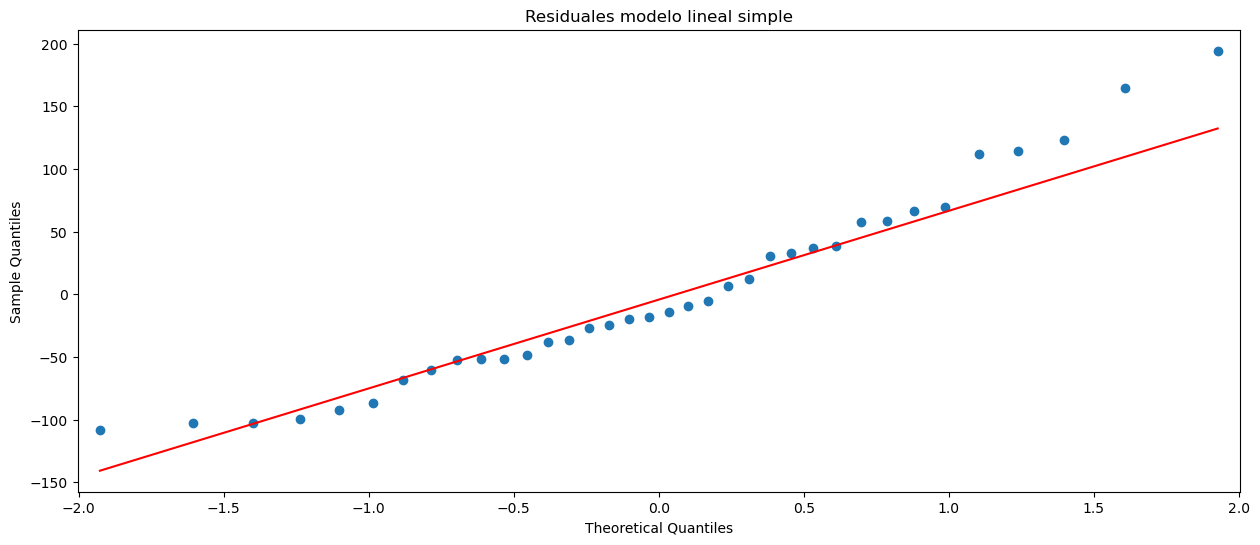

In [9]:
residuales = model.resid
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plt.title("Residuales modelo lineal simple")
sm.qqplot(residuales, line='q', ax=ax)
plt.show()

En un modelo perfecto, deberíamos observar que los residuos se distribuyen de forma normal, en el QQ Plot, deberíamos entonces observar que los residuos se ajustan perfectamente a la línea roja. No es el caso, el supuesto de los residuos no se cumple, por lo tanto, el modelo no hace un buen trabajo al explicar la variable dependiente.

Por medio de un histograma, podemos comprobar que los residuos no se comportan de forma normal.

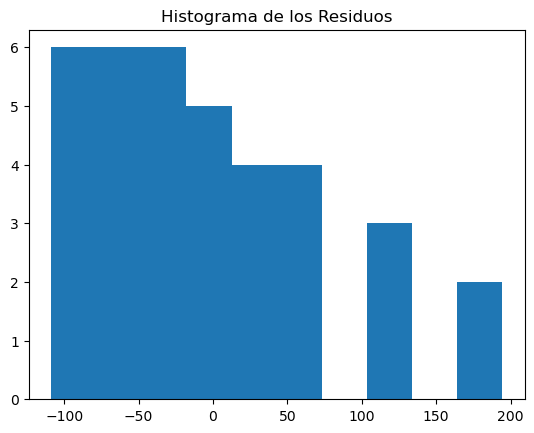

In [10]:
plt.title("Histograma de los Residuos")
plt.hist(residuales)
plt.show()

## Y si usamos un modelo polinomial?
Si solo un parámetro nos ayuda a explicar solamente la tendencia, quizás más parámetros podrían capturar lo demás no? Es una pregunta valida y se puede poner a prueba fácilmente al intentar calcular más features dentro de los datos de entrada. Miremos que pasa si intentamos entrenar un modelo de grado 10.

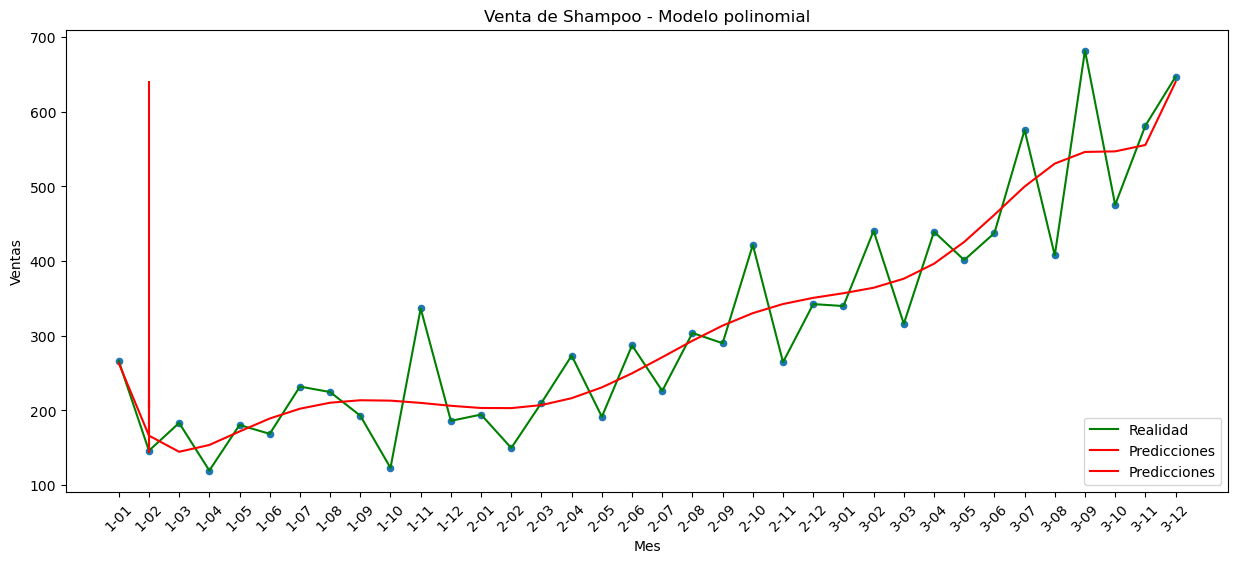

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=10, include_bias=False)

poly_features = poly.fit_transform(x, y)

poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

predicciones = poly_reg_model.predict(poly_features)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot.scatter(x='Month', y='Sales', ax=ax)
dataset.plot.line(x='Month', y='Sales', ax=ax, color="green", label="Realidad")
ax.plot(x, predicciones, color="red", label="Predicciones")
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.legend()
ax.tick_params(axis='x', labelrotation=45)
plt.title("Venta de Shampoo - Modelo polinomial")
plt.show()

Como podemos observar, se ajusta mucho mejor que un modelo lineal simple, pero aún está lejos de ser perfecto, e incluso si se ajustara perfectamente, no es una garantía de que el modelo sea lo suficientemente bueno como para hacer pronósticos futuros. Este tipo de modelos solo contemplan la relación entre la variable dependiente e independiente, pero no contempla las relaciones *regresivas* que pueden haber entre los datos, es decir, que un dato en $t=5$ puede llegar a depender de $0 <= t < 5$, es decir valores anteriores. Los modelos de regresión lineal no sierven en estos casos. Razón por la cual las series de tiempo tienen su propio conjunto de técnicas y como más adelante veremos, hay unas arquitecturas de redes neuronales que contemplan la relación secuencial de sus datos de entrada, lo cual hace posible su uso para este tipo de problemas.

(36, 9)